# Dataset Viewer

Ноутбук является утилитой для просмотра выбранной пары изображение+аннотация. Позволяет убедиться в достоверности работы **extract_data.ipynb** (на случай возникновения ошибок в, например, преобразовании системы координат для расчета параметров окна). Визуализация происходит через внутренний модуль DEM CNN, а параметры для неё берутся из конфигурационного файла.

## Подготовка

Скачиваем необходимые для работы библиотеки. Импортируем их. Из конфига берем данные для визуализации.

In [1]:
%pip install torch torchvision numpy rasterio matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import Tensor
from torchvision.tv_tensors import Image, BoundingBoxes
import rasterio
import numpy as np

from utils import plot
from config import IMAGE_SIZE, CLASSES_MAPPING

In [3]:
def get_sample(image_path: str, annotation_path: str, size: int) -> tuple[Image | Tensor, dict]:
    with rasterio.open(image_path) as src:
        image = src.read(out_shape=(size, size))
        image_nan = image.copy()
        image_nan[image == src.nodata] = np.nan
    
        image = image - np.nanmin(image_nan)
        image[np.isnan(image_nan)] = 0.  # should it really be 0. and not -1. or else?
        image = Image(image)
        
    boxes = torch.empty((0, 4), dtype=torch.float32)
    labels = torch.empty(0, dtype=torch.int64)
    scores = torch.ones(0, dtype=torch.float32)  # scores are filled with ones for viewer as they stand for ground truth
    if annotation_path:
        with open(annotation_path, encoding='utf-8') as f:
            annotations = f.readlines()

        boxes = torch.empty((len(annotations), 4), dtype=torch.float32)
        labels = torch.empty(len(annotations), dtype=torch.int64)
        scores = torch.ones(len(annotations), dtype=torch.float32)  # scores are filled with ones for viewer as they stand for ground truth

        for i, annotation in enumerate(annotations):
            label, x_min, y_min, x_max, y_max = map(float, annotation[:-2].split('\t'))
            x_min, x_max = map(lambda x: x * size / src.width, (x_min, x_max))
            y_min, y_max = map(lambda y: y * size / src.height, (y_min, y_max))

            boxes[i] = torch.as_tensor([x_min, y_min, x_max, y_max], dtype=torch.float32)
            labels[i] = torch.as_tensor(int(label))

    target = {'boxes': BoundingBoxes(boxes, format='XYXY', canvas_size=(size, size)), 'labels': labels, 'scores': scores}    

    return image, target

## Визуализация

Вручную задаём пути к интересующим файлам (желательно осмотреть ключевые файлы по их координатам во всех проектах). Визуализируем их через утилиту.

In [4]:
IMAGE_PATH: str = 'dataset/images/train/some.tif'  # put image path you want to check
ANNOTATION_PATH: str = 'dataset/annotations/train/some.txt'  # put annotation path you want to check

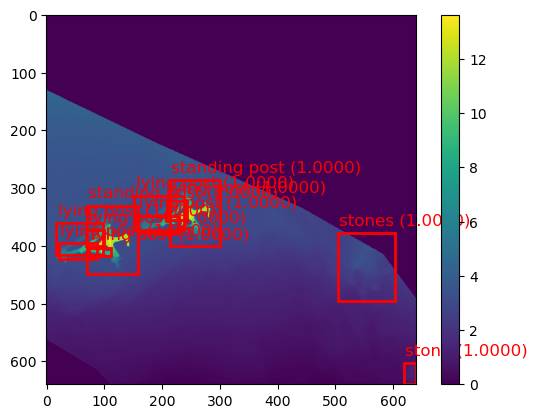

In [5]:
sample = get_sample(IMAGE_PATH, ANNOTATION_PATH, IMAGE_SIZE)

plot(*sample, CLASSES_MAPPING)